In [1]:
# this file runs testing on the results of our vae/dbscan model. 
# Note: the labeled data is labeled by me and not the best. we need a professional to label the data
#       if we want to know the exact results of our solution

In [2]:
import sys
import os
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import torch

sys.path.append(os.path.abspath(".."))
from particle_detection.data.data_pipeline import create_dataloaders

In [3]:
def evaluate_particle_detection(true_path, pred_path, threshold=10):
    """
    Evaluate particle detection performance by comparing ground truth and predicted coordinates.

    Parameters:
        true_path (str): Path to the CSV file containing ground truth coordinates.
        pred_path (str): Path to the CSV file containing predicted coordinates.
        threshold (float): Distance threshold to consider a detection as a match.

    Returns:
        dict: Dictionary containing evaluation metrics (TP, FP, FN, Precision, Recall, F1 Score).
    """
    try:
        true_df = pd.read_csv(true_path, usecols=["X", "Y"])
        pred_df = pd.read_csv(pred_path)
    except Exception as e:
        print(f"Error reading CSV files ({true_path}, {pred_path}): {e}")
        raise e

    true_coords = list(zip(true_df["X"], true_df["Y"]))
    pred_coords = list(zip(pred_df.iloc[:, 0], pred_df.iloc[:, 1]))

    true_tree = cKDTree(true_coords)
    matched_true_indices = set()
    TP = 0
    for pred in pred_coords:
        dist, idx = true_tree.query(pred, distance_upper_bound=threshold)
        if dist != np.inf and idx not in matched_true_indices:
            TP += 1
            matched_true_indices.add(idx)

    FP = len(pred_coords) - TP
    FN = len(true_coords) - TP

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return {
        "TP": TP,
        "FP": FP,
        "FN": FN,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }

In [4]:
def overlay_detection_results(img_tensor, true_path, pred_path, threshold=10, title="Detection Overlay"):
    """
    Overlay detection results on an image by comparing ground truth and predicted coordinates.

    Parameters:
        img_tensor (torch.Tensor): A tensor representing the image.
        true_path (str): Path to the CSV file containing ground truth coordinates.
        pred_path (str): Path to the CSV file containing predicted coordinates.
        threshold (float): Distance threshold for matching predictions.
        title (str): Title for the plot.
    """
    try:
        true_df = pd.read_csv(true_path, usecols=["X", "Y"])
        pred_df = pd.read_csv(pred_path)
    except Exception as e:
        print(f"Error reading CSV files for overlay ({true_path}, {pred_path}): {e}")
        return

    true_coords = list(zip(true_df["X"], true_df["Y"]))
    pred_coords = list(zip(pred_df.iloc[:, 0], pred_df.iloc[:, 1]))

    true_tree = cKDTree(true_coords)
    matched_true = set()
    TP_coords = []
    FP_coords = []

    for pred in pred_coords:
        dist, idx = true_tree.query(pred, distance_upper_bound=threshold)
        if dist != np.inf and idx not in matched_true:
            TP_coords.append(pred)
            matched_true.add(idx)
        else:
            FP_coords.append(pred)

    FN_coords = [true_coords[i] for i in range(len(true_coords)) if i not in matched_true]

    # Prepare the image for display.
    img = img_tensor.squeeze().cpu().numpy()
    if img.max() <= 1.0:
        img = (img * 255).astype(np.uint8)

    plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap="gray")
    if TP_coords:
        x_tp, y_tp = zip(*TP_coords)
        plt.scatter(x_tp, y_tp, facecolors="none", edgecolors="lime", label="TP", s=35, linewidths=0.5)
    if FP_coords:
        x_fp, y_fp = zip(*FP_coords)
        plt.scatter(x_fp, y_fp, facecolors="none", edgecolors="red", label="FP", s=35, linewidths=0.5)
    if FN_coords:
        x_fn, y_fn = zip(*FN_coords)
        plt.scatter(x_fn, y_fn, facecolors="none", edgecolors="orange", label="FN", s=35, linewidths=0.5)

    plt.legend()
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

In [7]:
def particle_count_accuracy(true_path, pred_path, threshold=10):
    """
    Compare the particle counts between true labels and predictions, and compute detection accuracy.
    
    Accuracy is defined as:
        (True Positives / Number of True Labeled Particles) * 100
        
    Parameters:
        true_path (str): Path to the CSV file containing true particle coordinates (with "X" and "Y" columns).
        pred_path (str): Path to the CSV file containing predicted particle coordinates.
        threshold (float): Distance threshold within which a prediction is considered a true positive.
        
    Returns:
        dict: A dictionary with:
            - true_count: Total number of true labeled particles.
            - predicted_count: Total number of predicted particles.
            - true_positive: Number of predictions that correctly match a true labeled particle.
            - accuracy: Detection accuracy as a percentage.
    """
    try:
        true_df = pd.read_csv(true_path, usecols=["X", "Y"])
        pred_df = pd.read_csv(pred_path)
    except Exception as e:
        print(f"Error reading CSV files: {e}")
        raise e

    true_count = len(true_df)
    predicted_count = len(pred_df)

    # Create coordinate lists.
    true_coords = list(zip(true_df["X"], true_df["Y"]))
    pred_coords = list(zip(pred_df.iloc[:, 0], pred_df.iloc[:, 1]))

    # Build a KD-Tree for true coordinates.
    true_tree = cKDTree(true_coords)
    matched_true_indices = set()
    true_positive = 0

    # For each prediction, see if it falls within the threshold of a true coordinate.
    for pred in pred_coords:
        dist, idx = true_tree.query(pred, distance_upper_bound=threshold)
        if dist != np.inf and idx not in matched_true_indices:
            true_positive += 1
            matched_true_indices.add(idx)

    accuracy = (true_positive / true_count * 100) if true_count > 0 else 0

    return {
        "true_count": true_count,
        "predicted_count": predicted_count,
        "true_positive": true_positive,
        "accuracy": accuracy
    }

In [5]:
csv_dir = os.path.join("..", "saved_models", "csv")
image_dir = os.path.join("..", "data")
threshold = 10
batch_size = 8
num_tests = 3 

# Evaluate detection metrics for test images.
all_results = []
for i in range(num_tests):
    true_csv = os.path.join(csv_dir, f"labeled_test_{i}.csv")
    pred_csv = os.path.join(csv_dir, f"predicted_test_{i}.csv")
    try:
        result = evaluate_particle_detection(true_csv, pred_csv, threshold=threshold)
        all_results.append(result)
    except Exception as e:
        print(f"Skipping test_{i} due to error: {e}")

results_df = pd.DataFrame(all_results)
print("Evaluation Results:")
print(results_df)

Evaluation Results:
    TP   FP   FN  Precision    Recall  F1 Score
0  290   98   90   0.747423  0.763158  0.755208
1  252  120   93   0.677419  0.730435  0.702929
2  312  173  198   0.643299  0.611765  0.627136


Using device: cuda
Test batch shape: torch.Size([3, 1, 2048, 2048])
Overlaying detection results for test_0


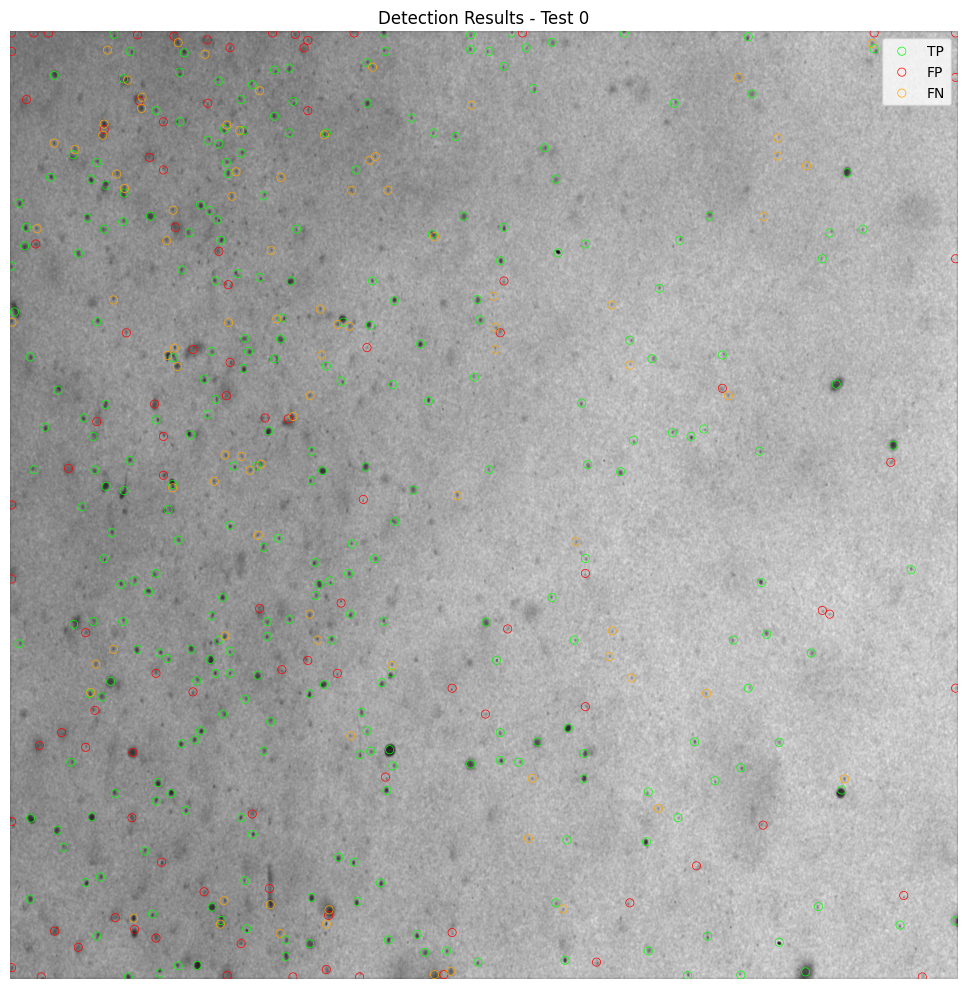

Particles Labeled: 380
Particles Predicted: 388
True Positives: 290
Detection Accuracy: 76.32% 

Overlaying detection results for test_1


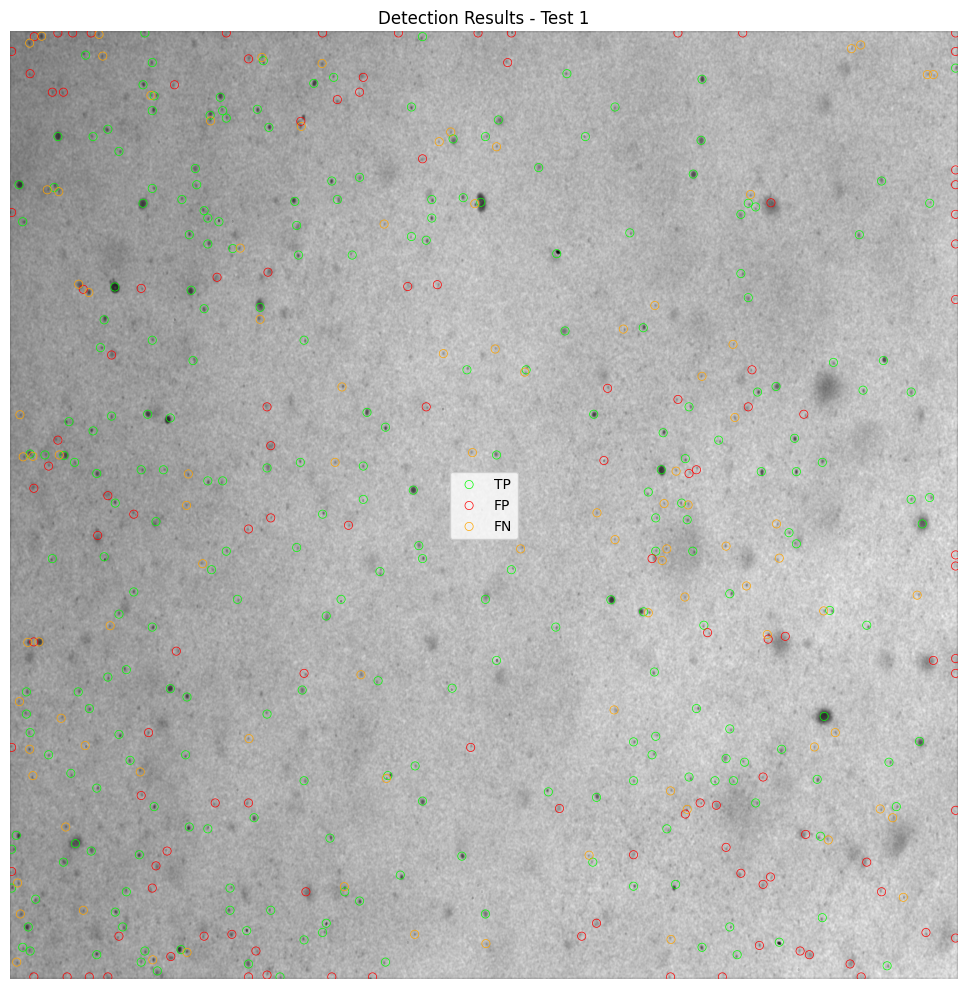

Particles Labeled: 345
Particles Predicted: 372
True Positives: 252
Detection Accuracy: 73.04% 

Overlaying detection results for test_2


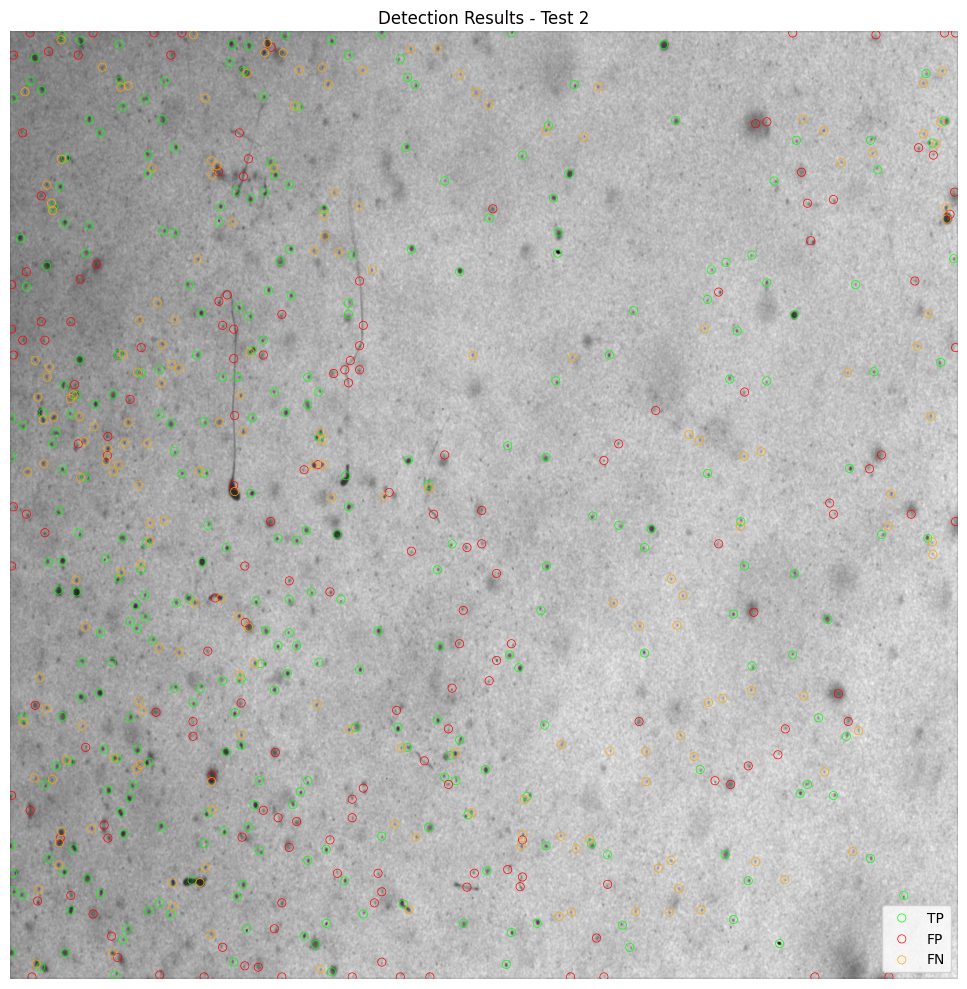

Particles Labeled: 510
Particles Predicted: 485
True Positives: 312
Detection Accuracy: 61.18% 



In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
try:
    _, test_loader = create_dataloaders(data_dir=image_dir, image_size=(2048, 2048), batch_size=batch_size)
except Exception as e:
    print(f"Error creating dataloaders: {e}")
    sys.exit(1)

try:
    test_batch = next(iter(test_loader))
except StopIteration:
    print("Test dataloader is empty.")
    sys.exit(1)

print(f"Test batch shape: {test_batch.shape}")

# Loop through the entire test batch and overlay detection results.
for i, img_tensor in enumerate(test_batch):
    true_csv = os.path.join(csv_dir, f"labeled_test_{i}.csv")
    pred_csv = os.path.join(csv_dir, f"predicted_test_{i}.csv")
    print(f"Overlaying detection results for test_{i}")
    overlay_detection_results(
        img_tensor=img_tensor,
        true_path=true_csv,
        pred_path=pred_csv,
        threshold=threshold,
        title=f"Detection Results - Test {i}"
    )
    result = particle_count_accuracy(true_csv, pred_csv, threshold=10)
    print(f"Particles Labeled: {result['true_count']}")
    print(f"Particles Predicted: {result['predicted_count']}")
    print(f"True Positives: {result['true_positive']}")
    print(f"Detection Accuracy: {result['accuracy']:.2f}% \n")